In [48]:
from pathlib import Path
import json
import pickle
from itertools import cycle
from typing import Iterable, List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

%matplotlib inline

In [49]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
DATA_ROOT = Path('../trajectories/diffusion')

# Pickled matplotlib figures written by save_static_map_backgrounds()
COSTMAP_PICKLE = DATA_ROOT / 'costmap_background.pkl'
POLYGON_PICKLE = DATA_ROOT / 'polygon_background.pkl'

# Declare path overlays by referencing the pickle produced for that planner/run.
# Provide the file name and a label (and optionally a custom color).
PATH_PICKLES: List[Dict[str, Any]] = [
    {"label": "Diffusion", "pickle": '../trajectories/diffusion/path_lines.pkl', "color": 'tab:orange'},
    {"label": "NMPC", "pickle": '../trajectories/nmpc/path_lines.pkl', "color": 'tab:green'},
    {"label": "A*", "pickle": '../trajectories/astar/path_lines.pkl', "color": 'tab:purple'}
    # Example: {"label": "Diffusion", "pickle": DATA_ROOT / 'diffusion_path_lines.pkl', "color": 'tab:red'}
    # Example: {"label": "MPC", "pickle": DATA_ROOT / 'mpc_path_lines.pkl'}
]

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['tab:red', 'tab:blue', 'tab:green'])
LINEWIDTH = 2.0

# Ship footprint matches the baseline SIM2D configuration
SHIP_VERTICES = np.asarray([
    [43.1, 0.0],
    [35.4, 4.0],
    [27.5, 6.5],
    [11.6, 9.0],
    [-33.1, 9.0],
    [-33.1, -9.0],
    [11.6, -9.0],
    [27.5, -6.5],
    [35.4, -4.0],
], dtype=float)
DEFAULT_SHIP_HEADING = np.pi / 2  # fallback yaw if pathline has a single point
SHIP_FACE_COLOR = 'white'
SHIP_EDGE_COLOR = 'black'
SHIP_FACE_ALPHA = 0.6


In [50]:
def _normalize_color(color):
    if color is None:
        return None
    if isinstance(color, (list, tuple)):
        return tuple(color)
    return color


def load_axes_background(pickle_path: Path) -> Dict[str, Any]:
    pickle_path = Path(pickle_path)
    if not pickle_path.exists():
        raise FileNotFoundError(f'Background file not found: {pickle_path}')
    with open(pickle_path, 'rb') as fh:
        fig = pickle.load(fh)
    if not fig.axes:
        raise ValueError(f'No axes available in {pickle_path}')
    src_ax = fig.axes[0]
    state = {
        'facecolor': _normalize_color(src_ax.get_facecolor()),
        'xlim': src_ax.get_xlim(),
        'ylim': src_ax.get_ylim(),
        'aspect': src_ax.get_aspect(),
        'xlabel': src_ax.get_xlabel(),
        'ylabel': src_ax.get_ylabel(),
        'title': src_ax.get_title(),
        'images': [],
        'patches': [],
    }
    for image in src_ax.get_images():
        state['images'].append({
            'array': np.array(image.get_array()),
            'origin': getattr(image, 'origin', 'upper'),
            'cmap': image.get_cmap().name if image.get_cmap() else None,
            'vmin': image.norm.vmin if image.norm else None,
            'vmax': image.norm.vmax if image.norm else None,
            'alpha': image.get_alpha(),
        })
    for patch in src_ax.patches:
        if isinstance(patch, patches.Polygon):
            state['patches'].append({
                'xy': np.array(patch.get_xy()),
                'closed': patch.get_closed(),
                'edgecolor': _normalize_color(patch.get_edgecolor()),
                'facecolor': _normalize_color(patch.get_facecolor()),
                'linewidth': patch.get_linewidth(),
                'alpha': patch.get_alpha(),
            })
    plt.close(fig)
    return state


def draw_background(ax, state: Dict[str, Any]) -> None:
    ax.set_facecolor(state['facecolor'])
    for image in state['images']:
        ax.imshow(
            image['array'],
            origin=image['origin'],
            cmap=image['cmap'],
            vmin=image['vmin'],
            vmax=image['vmax'],
            alpha=image['alpha']
        )
    for patch_state in state['patches']:
        patch = patches.Polygon(
            patch_state['xy'],
            closed=patch_state['closed'],
            edgecolor=patch_state['edgecolor'],
            facecolor=patch_state['facecolor'],
            linewidth=patch_state['linewidth'],
            alpha=patch_state['alpha']
        )
        ax.add_patch(patch)
    ax.set_xlim(state['xlim'])
    ax.set_ylim(state['ylim'])
    ax.set_aspect(state['aspect'])
    if state['title']:
        ax.set_title(state['title'])


def load_pathline_from_pickle(pickle_path: Path) -> Dict[str, np.ndarray]:
    pickle_path = Path(pickle_path)
    if not pickle_path.exists():
        raise FileNotFoundError(f'Path line pickle not found: {pickle_path}')
    with open(pickle_path, 'rb') as fh:
        fig = pickle.load(fh)
    try:
        if not fig.axes:
            raise ValueError(f'No axes available in {pickle_path}')
        src_ax = fig.axes[0]
        if not src_ax.lines:
            raise ValueError(f'No path lines stored in {pickle_path}')
        line = src_ax.lines[0]
        x = np.asarray(line.get_xdata(), dtype=float)
        y = np.asarray(line.get_ydata(), dtype=float)
        return {'x': x, 'y': y}
    finally:
        plt.close(fig)


def prepare_paths(specs: Iterable[Dict[str, Any]], default_colors: List[str]) -> List[Dict[str, Any]]:
    paths = []
    color_cycle = cycle(default_colors)
    for spec in specs:
        entry = load_pathline_from_pickle(spec['pickle'])
        color = spec.get('color') or next(color_cycle)
        label = spec.get('label') or Path(spec['pickle']).stem
        paths.append({
            'label': label,
            'color': color,
            'x': entry['x'],
            'y': entry['y'],
        })
    return paths


def _rotation_matrix(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])


def compute_initial_heading(x_coords: np.ndarray, y_coords: np.ndarray) -> float:
    if x_coords.size >= 2:
        dx = x_coords[1] - x_coords[0]
        dy = y_coords[1] - y_coords[0]
        if np.hypot(dx, dy) > 1e-6:
            return float(np.arctan2(dy, dx))
    return DEFAULT_SHIP_HEADING


def draw_ship_outline(ax, x: float, y: float, heading: float, edgecolor: str = SHIP_EDGE_COLOR) -> patches.Polygon:
    vertices = SHIP_VERTICES @ _rotation_matrix(heading).T + np.array([x, y])
    patch = patches.Polygon(
        vertices,
        closed=True,
        edgecolor=edgecolor,
        facecolor=SHIP_FACE_COLOR,
        linewidth=1.5,
        alpha=SHIP_FACE_ALPHA,
        zorder=10,
    )
    ax.add_patch(patch)
    return patch


In [51]:
costmap_background = load_axes_background(COSTMAP_PICKLE)
polygon_background = load_axes_background(POLYGON_PICKLE)
path_entries = prepare_paths(PATH_PICKLES, DEFAULT_COLORS)

print(f'Loaded costmap background from: {COSTMAP_PICKLE}')
print(f'Loaded polygon background from: {POLYGON_PICKLE}')
print(f'Loaded {len(path_entries)} path set(s).')


Loaded costmap background from: ../trajectories/diffusion/costmap_background.pkl
Loaded polygon background from: ../trajectories/diffusion/polygon_background.pkl
Loaded 3 path set(s).


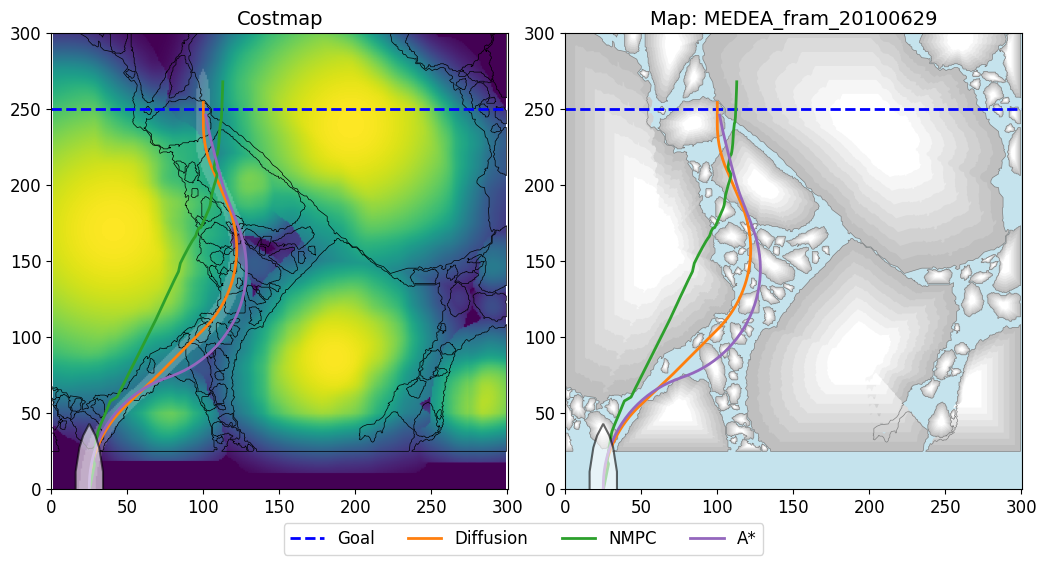

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=False)
draw_background(axes[0], costmap_background)
draw_background(axes[1], polygon_background)

# Add horizontal goal line at y=250 for both plots
goal_line = axes[0].axhline(y=250, color='blue', linestyle='--', linewidth=2.0, label='Goal')
axes[1].axhline(y=250, color='blue', linestyle='--', linewidth=2.0, label='Goal')

handles = [goal_line]
labels = ['Goal']
if path_entries:
    for entry in path_entries:
        line, = axes[0].plot(entry['x'], entry['y'], color=entry['color'], linewidth=LINEWIDTH)
        axes[1].plot(entry['x'], entry['y'], color=entry['color'], linewidth=LINEWIDTH)
        handles.append(line)
        labels.append(entry['label'])
else:
    print('PATH_PICKLES is empty; add entries to overlay path lines.')

# Draw the ship outline where the path originates (bottom-left)
heading = compute_initial_heading(entry['x'], entry['y'])
draw_ship_outline(
    axes[0],
    x=float(entry['x'][0]),
    y=float(entry['y'][0]),
    heading=heading,
)
draw_ship_outline(
    axes[1],
    x=float(entry['x'][0]),
    y=float(entry['y'][0]),
    heading=heading,
)

axes[0].set_title("Costmap", fontsize=14)
axes[1].set_title("Map: MEDEA_fram_20100629", fontsize=14)

# Increase font size for axis labels and ticks
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)

if handles:
    fig.legend(handles, labels, loc='lower center', ncol=max(1, min(len(handles), 4)), fontsize=12)
fig.subplots_adjust(bottom=0.12, wspace=-0.1)
plt.savefig("controllers.pdf")
plt.show()
